# PRA2: Limpieza y análisis de los datos
### Alumno: Julio Zamora Guerrero - jzamgu2

En esta práctica vamos a aplicar de forma transversal algunos de los conocimientos adquiridos en esta asignatura, así como de técnicas aprendidas en otras asignaturas del Master de Ciencia de Datos.

Así pues, definiremos el dataset escogido, lo limpiaremos y aplicaremos dos técnicas de reducción de dimensionalidad, para posteriormente aplicar un modelo de clasificación sencillo (árbol de decisión) y ver si estas técnicas de reducción de dimensionalidad son adecuadas para aumentar la precisión del clasificador, usando técnicas de validación cruzada. 
   
Para realizar esta práctica, necesitaremos las siguientes librerías:

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import datasets
from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from six import StringIO
import math
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

%matplotlib inline

# Descripción del dataset

En primer lugar, debéis cargar el conjunto de datos Wine recognition (más información en el enlace https://archive.ics.uci.edu/ml/datasets/Wine). Se puede descargar de internet o se puede cargar directamente desde la librería "scikit-learn", que incorpora un conjunto de datasets muy conocidos y usados para la minería de datos y machine learning: [http://scikit-learn.org/stable/datasets/index.html](http://scikit-learn.org/stable/datasets/index.html).

Estos datos son el resultado de un análisis químico de vinos de tres diferentes cultivos en la misma región de Italia. El análisis se basa en las diferencias entre 13 variables que describen el vino.

Este dataset es perfecto para aplicar técnicas de clasificación, tras su correcto preprocesado.

# Integración y selección de los datos de interés a analizar.
Para empezar, vamos a cargar el conjunto desde sklearn, lo pasamos a un dataframe de pandas y mostramos sus propiedades.

In [2]:
data = datasets.load_wine(as_frame=True)
df = pd.DataFrame(data.frame)
print('El conjunto de datos se compone de {} filas, y {} atributos.'.format(df.shape[0], df.shape[1]))
print('\nLos atributos son los siguientes:\n{}'.format(list(df.columns)))

El conjunto de datos se compone de 178 filas, y 14 atributos.

Los atributos son los siguientes:
['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline', 'target']


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
 13  targe

Como hemos comentado en la descripción del dataset, observamos que el dataset se componen de las 13 variables de las propiedades del vino y de la variable 'target', la cual sirve de etiqueta para entrenar los posibles modelos de clasificación.

Antes de continuar, guardamos los datos originales en un csv.

In [4]:
df.to_csv(os.getcwd() + '\\wine_original.csv')

De momento vamos a dejar todas las columnas, ya que a priori no podemos determinar cuales son las más significativas, por lo que podemos proceder con el siguiente punto.

# Limpieza de los datos

Vamos a empezar comprobando si existen valores nulos.

In [5]:
df[df.isna().any(axis=1)]

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target


Como vemos no existe ningún valor nulo en el dataframe generado, lo cual nos facilita su análisis. La forma de actuar ante la ausencia de determinados datos puede variar en función de la cantidad de los mismos y la extensión del dataset. En este caso nuestro dataset se compone solamente de 178 filas, por lo que la existencia de datos vacíos sería problemática.

Prosigamos con analizando los valores extremos, para ello vamos a proceder a explorar cada columna de forma independiente mediante un diagrama de cajas, además también mostraremos un histograma para ver la distribución de los datos.

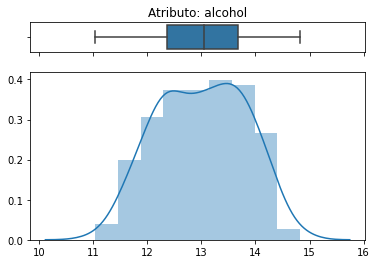

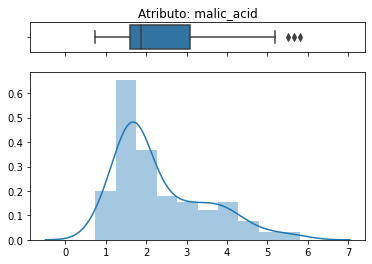

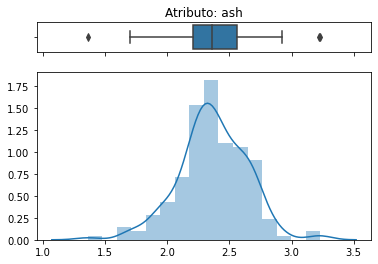

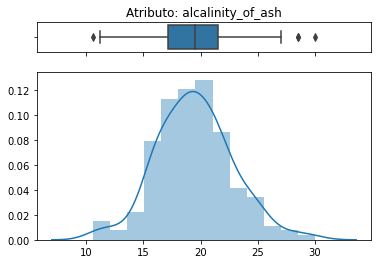

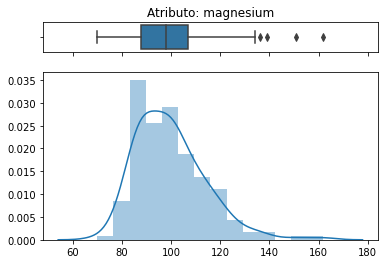

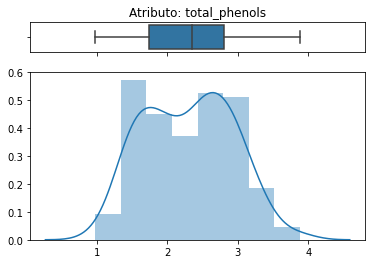

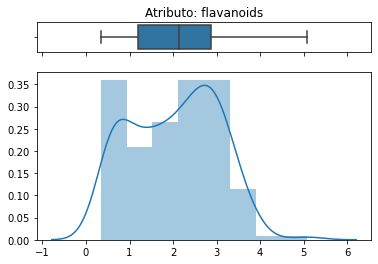

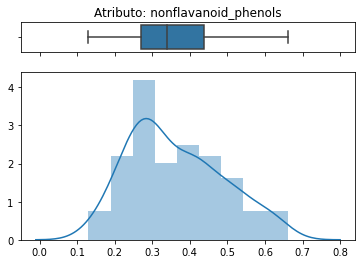

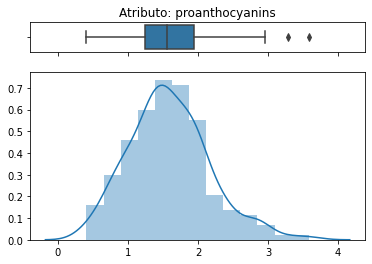

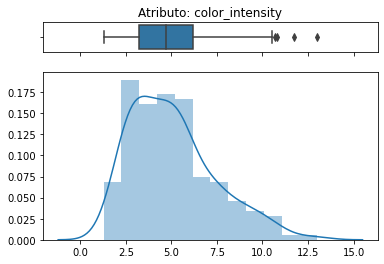

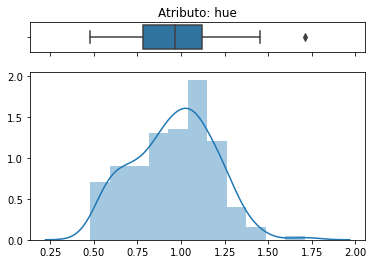

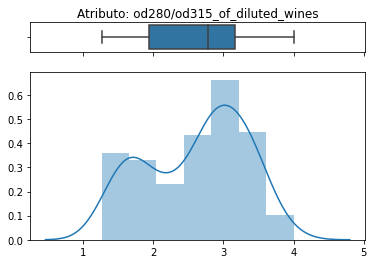

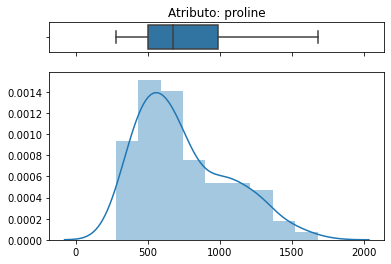

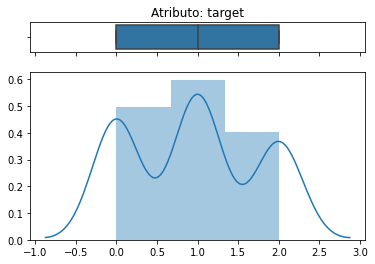

In [6]:
for column in df.columns:
  
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

    sns.boxplot(df[column], ax=ax_box).set_title('Atributo: ' + column)
    sns.distplot(df[column], ax=ax_hist)

    ax_box.set(xlabel='')
    ax_hist.set(xlabel='')

Gracias a esta exploración inicial hemos podido ver que existen datos atípicos en varios atributos (como ash, magnesium y hue). Sin embargo, debido a que el dataset cuenta con tan solo 178 registros, hemos de dejar estos datos atípicos, ya que aplicar una técnica de sustitución (por ejemplo con la media), podría afectar al desempeño de las técnicas que vamos a desarrollar.

Para completar, veamos un resumen de los estadísticos descriptivos de todos los atributos

In [7]:
df.describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258,0.938202
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474,0.775035
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000,0.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000,0.000000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000,1.000000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000,2.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000,2.000000


Aunque ya hemos realizado un histograma de todos los atributos, vamos a proceder a calcular la frecuencia de cada clase y las representamos mediante un sencillo gráfico de barras.

0    59
1    71
2    48
Name: target, dtype: int64


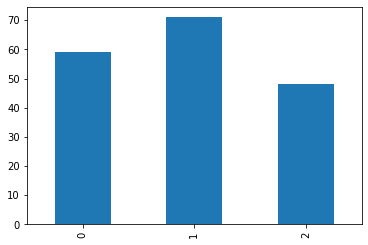

In [8]:
freqs = df['target'].value_counts().sort_index()
print(freqs)
freqs.plot.bar()

# Análisis de los datos

Debido a la complejidad de los atributos, vamos a centrarnos en tres atributos principales para realizar el análisis exploratorio: alcohol, magnesium y color_intensity.

Podemos observar que el dataset se compone de 178 observaciones de vinos, categorizadas en 3 grupos (0, 1, 2), siendo la categoría 1 la que tiene un mayor número de registros en el dataset (71 de 178).
Si observamos los histogramas de los atributos seleccionamos, apreciamos una distribución trimodal simétrica para alcohol, y distribuciones con asimetría a la derecha para magnesium y color_intensity.

A continuación vamos a realizar un análisis gráfico más exhaustivo de estos parámetros seleccionados. La finalidad es observar cómo se distribuye cada uno de los atributos en función de la clase que tengan, para poder identificar de manera visual y rápida si algunos atributos permiten diferenciar de forma clara las diferentes clases de vinos.

In [9]:
feats_to_explore = ['alcohol', 'magnesium', 'color_intensity']

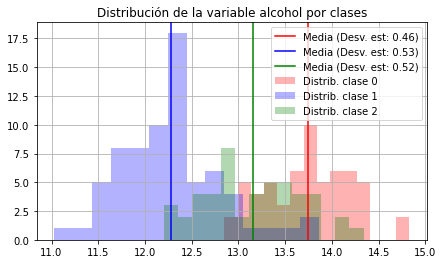

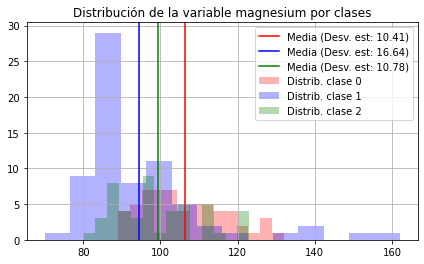

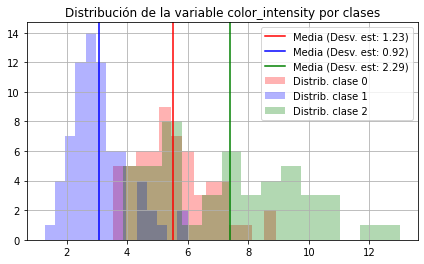

In [10]:
nbins = math.ceil(math.sqrt(df.shape[0]))
colors = ['r', 'b', 'g']
for feat in feats_to_explore:
    plt.figure()
    for target, color in zip(df['target'].unique(), colors):
        histo = df[df['target'] == target][feat].hist(bins=nbins, figsize=(7,4), alpha=0.3, label='Distrib. clase ' + str(target), color=color)
        vline = plt.axvline(df[df['target'] == target][feat].mean(), color=color, label='Media (Desv. est: ' + str(round(np.std(df[df['target'] == target][feat]), 2)) + ')')
    plt.legend()
    plt.title('Distribución de la variable ' + feat + ' por clases')
    plt.show()

A priori parece que el atributo que parece tener más peso para la clasificación es el alcohol, ya que es la que presenta las distribuciones de las clases más separadas, siendo la variable magnesium la que parece tener menos peso para la clasificación debido a que sus distribuciones se encuentran más entrelazadas.

Vamos a calcular una matriz de correlación entre las tres variables elegidas.

In [11]:
corr_matrix = df.loc[:, feats_to_explore].corr()
corr_matrix

,alcohol,magnesium,color_intensity
alcohol,1.000000,0.270798,0.546364
magnesium,0.270798,1.000000,0.199950
color_intensity,0.546364,0.199950,1.000000


Observamos cierta correlación entre el alcohol y color_intensity. Vamos a confirmarlo gráficamente mediante un scatterplot.

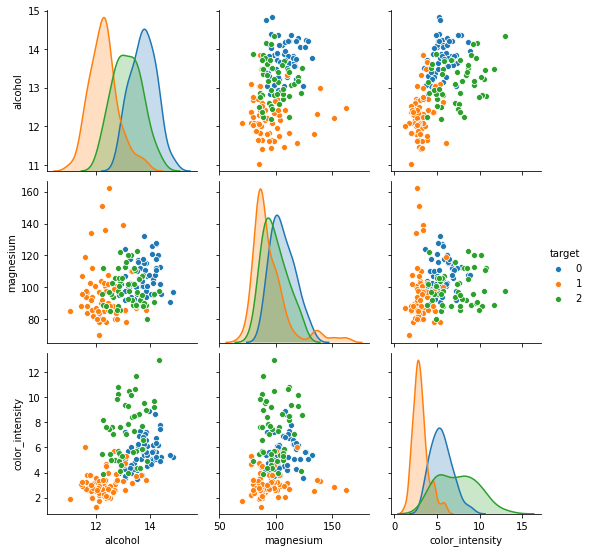

In [12]:
feats_to_explore = ['alcohol', 'magnesium', 'color_intensity', 'target']
sns.pairplot(df.loc[:, feats_to_explore], hue='target')

Los resultados de la matriz de correlación nos indican que la mayor correlación es la del par alcohol y color_intensity. Observando los resultados gráficos vemos que esta correlación se da especialmente en aquellos vinos de clase 0 y 1, estándo más dispersa la relación entre estos atributos de aquellos valores para los vinos de la clase 2.

Hemos aplicado la matriz de correlación. Sin embargo, lo hemos hecho solamente usando solo tres atributos. Con el objetivo de aplicar otras técnicas, vamos a aplicar métodos de reducción de la dimensionalidad al conjunto original de datos. El objetivo es reducir el conjunto de atributos a un nuevo conjunto con menos dimensiones. Así en vez de trabajar con 3 variables elegidas al azar, usaremos la información de todos los atributos.

Para ello, empezamos aplicaremos el método de reducción de la dimensionalidad, Principal Component Analysis (PCA), para reducir a 2 dimensiones el dataset entero con todas las features. Generaremos un gráfico en 2D con el resultado del PCA usando colores diferentes para cada una de las clases de la respuesta (wine_class), con el objetivo de visualizar si es posible separar eficientemente las clases con este método. Además exportamos el csv para completar el repositorio.


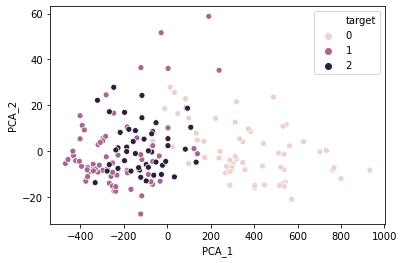

In [13]:
pca = PCA(n_components = 2)
#Sacamos target de df
array2D_pca = pca.fit_transform(df.iloc[:,:-1])
df2D_pca = pd.DataFrame(array2D_pca, columns = ['PCA_1', 'PCA_2'])
df2D_pca['target'] = df['target']
sns.scatterplot(data=df2D_pca, x='PCA_1', y='PCA_2', hue='target')
df2D_pca.to_csv(os.getcwd() + '\\wine_pca.csv')


Seguimos aplicando otra técnica dereducción de dimensionalidad, en este caso usando TSNE.

Igual que antes, generaremos un gráfico en 2D con el resultado del PCA usando colores diferentes para cada una de las clases de la respuesta (wine_class), con el objetivo de visualizar si es posible separar eficientemente las clases con este método. De nuevo exportamos el csv. 


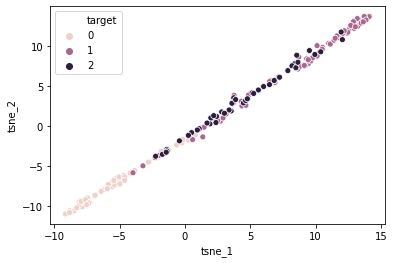

In [14]:
tsne = TSNE(n_components=2, perplexity=30)
#Sacamos target de df
array2D_tsne = tsne.fit_transform(df.iloc[:,:-1])
df2D_tsne = pd.DataFrame(array2D_tsne, columns = ['tsne_1', 'tsne_2'])
df2D_tsne['target'] = df['target']
sns.scatterplot(data=df2D_tsne, x='tsne_1', y='tsne_2', hue='target')
df2D_tsne.to_csv(os.getcwd() + '\\wine_tsne.csv')

Ambos métodos parecen haber funcionado bien, reduciendo los atributos desde 13 hasta 2. Gráficamente TSNE parece separar las clases con mayor éxito.
Ambas técnicas son distintas, aunque hagan la misma función, para este caso en concreto parece venir mejor TSNE, ya que PCA necesita que las variables tengan más correlación entre sí.

Llegados a este punto, vamos a aplicar un método de aprendizaje supervisado, concretamente el clasificador Decision Tree (un árbol de decisión), para predecir la clase a la que pertenece cada vino y evaluar la precisión obtenida con el modelo. Para eso usaremos:

    - El conjunto de datos reducido a sólo 2 atributos con PCA
    - El conjunto de datos reducido a sólo 2 atributos con TSNE
    - El conjunto de datos original con todos los atributos

Los pasos a realizar para los tres conjuntos de datos son:
    
     - Dividir el dataset en train y test.
     - Definir un modelo Decision Tree (fijando max_depth = 5 para mantener el modelo simple).
     - Aplicar validación cruzada con el modelo definido y el dataset de train.
     - Calcular la media y la desviación estándar de la validación cruzada.

Para facilitarnos el trabajo, vamos a crear una función (train_test) que nos sirva para los tres conjuntos de datos:

In [15]:
def train_test(df):
    X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:-1], df.iloc[:,-1], test_size=0.2, random_state=42)
    tree1 = DecisionTreeClassifier(max_depth=5)
    tree1.fit(X_train, y_train)
    results = cross_val_score(tree1, X_train, y_train, cv=5)
    print('\nLa media de la validación cruzada es del {} %, y su desviación estándar {} %. para el dataset.\n'.format(round(np.mean(results) * 100, 2), round(np.std(results) * 100, 3)))
    fn = X_train.columns
    cn = ['0', '1', '2']
    fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
    plot_tree(tree1,
                   feature_names = fn, 
                   class_names=cn,
                   filled = True);
    fig.savefig('tree.png')
    return tree1, X_test, y_test

Aplicamos la función al dataset reducido a 2 dimensiones con PCA


La media de la validación cruzada es del 68.99 %, y su desviación estándar 4.211 %. para el dataset.



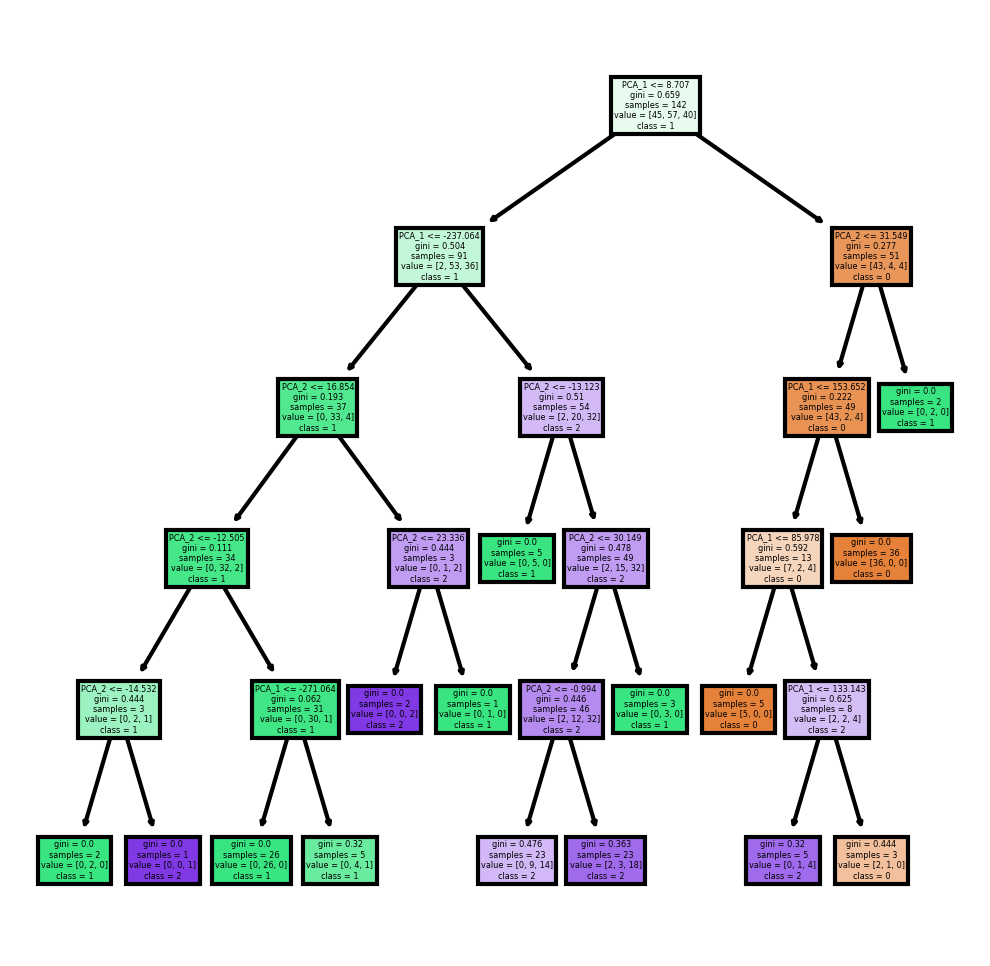

In [16]:
con_pca, X_test, y_test = train_test(df2D_pca)

Repetimos el mismo procedimiento que en el ejercicio anterior con el dataset reducido a 2 dimensiones con TSNE.



La media de la validación cruzada es del 68.37 %, y su desviación estándar 4.504 %. para el dataset.



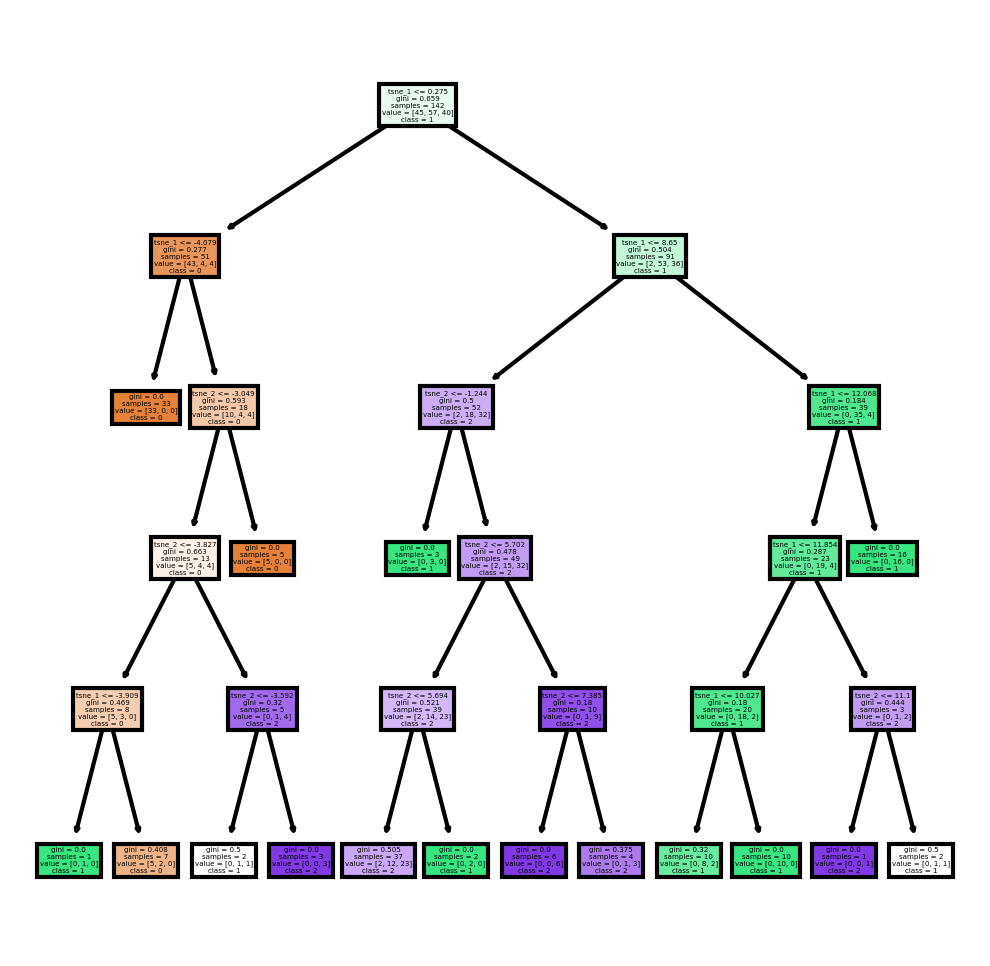

In [17]:
con_tsne, X_test, y_test = train_test(df2D_tsne)

Repetimos una vez más, esta vez con los datos originales.


La media de la validación cruzada es del 91.53 %, y su desviación estándar 1.832 %. para el dataset.



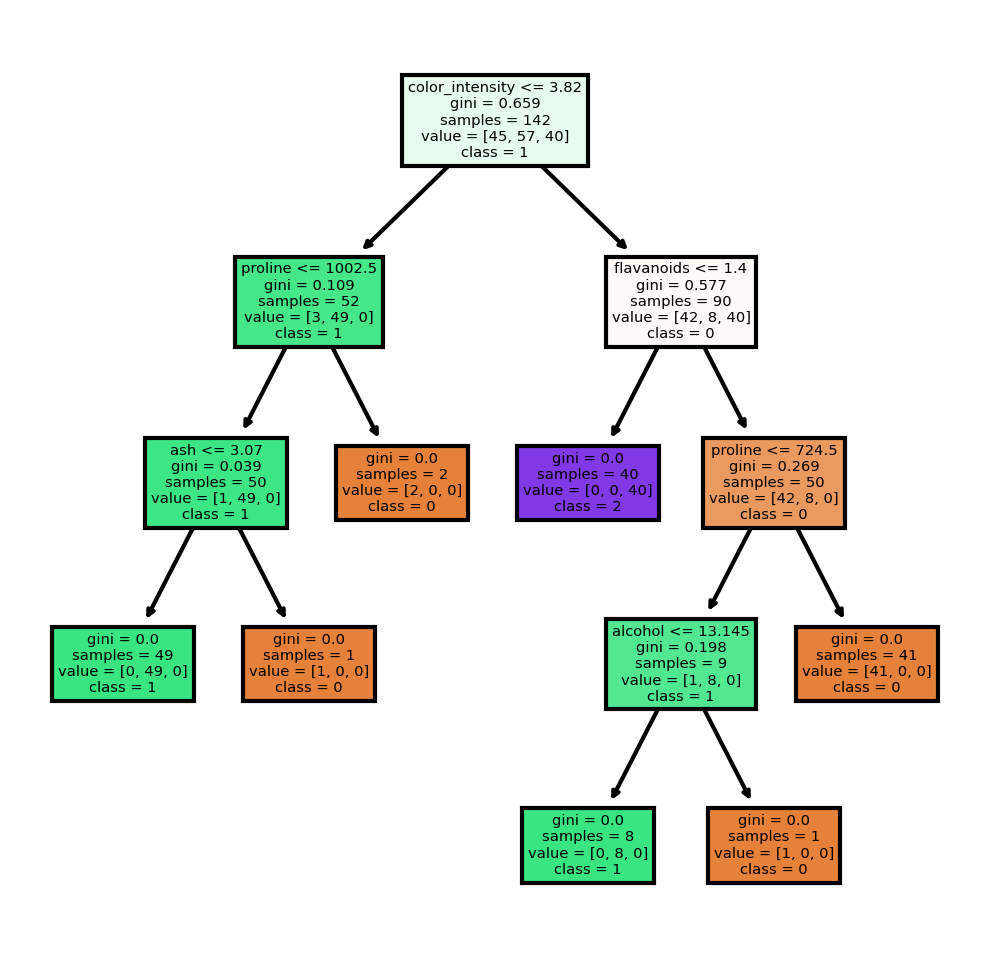

In [18]:
original, X_test, y_test = train_test(df)

# Resultados y conclusiones

El dataset que mejor ha funcionado ha sido el original. El árbol clasifica nuevos datos usando los atributos color_intensity, flavanoids, proline, ash y malic_acid.

Los métodos de reducción de dimensionalidad tienen la desventaja de que no consiguen conservar toda la información.
Por tanto, estos resultados tienen sentido, ya que esperábamos un mejor resultado en el dataset con los datos originales (13 atributos).

Con los datos originales vamos a generad predicciones sobre el dataset de test y a calcular la precisión de las predicciones obtenidas y la matriz de confusión asociada.

In [19]:
y_pred = original.predict(X_test)

Los resultados finales son los siguientes:

In [20]:
print('Accuracy score: {} %'.format(round(accuracy_score(y_test, y_pred) * 100, 2)))
print('\nMatriz de confusión:')
confusion_matrix(y_test, y_pred)

Accuracy score: 94.44 %

Matriz de confusión:


array([[13,  1,  0],
       [ 0, 14,  0],
       [ 1,  0,  7]], dtype=int64)

Donde observamos una precisión del 94.44 %, donde solo dos datos no han sido correctamente clasificados según la matriz de confusión.

Con esto se da por finalizada la práctica, en la que extraemos la conclusión principal de que la aplicación de modelos de reducción de dimensionalidad no son adecuados para el dataset Wine debido a que baja el desempeño del clasificador al perderse mucha información al reducir a dos dimensiones y además es contraproducente ya que es dificil de interpretar el arbol de decisión usando variables reducidas.